<a href="https://colab.research.google.com/github/pratik98/Social-Media-Seminar-19/blob/master/ANOVA_ANCOVA_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data retrieval

Execute the following code to get the data

In [0]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import scipy.stats as stats


response = requests.get("https://www.soscisurvey.de/adssurvey/?act=PDNNieOgNBRaJj1Y8ZGv922P")

#Likert scale values
STRONGLY_DISAGREE = 1
DISAGREE = 2
NEUTRAL = 3
AGREE = 4
STRONGLY_AGREE = 5
#Mistakes conditions
NO_MISTAKES = 1
TYPOS = 2
GRAMMOS = 3
#Knwledge on given social network
IGNORES_SOCIAL_NET = 4

def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

keys_dict = {   'AC01':'att_check' #"1": "strongly disagree", "5": "strongly agree"
              , 'DQ01':'age'
              , 'DQ02':'gender'
              , 'DQ03_01':'grammar_importance'
              , 'DQ04':'education'
              , 'DQ05':'native_lang'
              , 'DV01_02':'intelligence'
              , 'IV01':'mistakes' #"1": "No Mistakes","2": "Typos", "3": "Grammos"
              , 'IV02':'social_net'
              , 'MC01_02':'manip_check'
              , 'MC02':'sn_knowledge' #"4": "I have no idea about it"
            }

all_data = pd.DataFrame(response.json()['data']).transpose()
filtered_data = all_data.filter(all_data.filter(items = keys_dict.keys()).columns, axis = 1)
filtered_data.rename(columns = keys_dict, inplace=True)

#response = requests.get("https://www.soscisurvey.de/adssurvey/?act=PDNNieOgNBRaJj1Y8ZGv922P&cases=none&infoValues")
#jprint(response.json())
#print(" --- All columns' explanation above ---")

filtered_data.reset_index(drop = True, inplace = True)
filtered_data['intelligence'] = filtered_data['intelligence'].astype(float)
filtered_data.sample(5)

,att_check,age,gender,grammar_importance,education,native_lang,intelligence,mistakes,social_net,manip_check,sn_knowledge
32,2,6,1,4,5,2,1.0,3,2,5,3
46,2,3,1,4,1,2,5.0,2,2,2,3
96,1,4,1,5,4,1,1.0,3,1,5,1
34,2,3,2,5,2,2,3.0,2,2,5,4
94,1,4,1,4,5,1,1.0,3,1,5,2


## Data preprocessing

Apply manipulation/attention checks to filter the valid data.

Number of participants:  119 (Natives: 39 )
Valid answers:  58
Unnoticed mistakes:  24
Noticed mistakes when there were no mistakes:  8
Participants that didn't pay attention to the social net:  23
Participants that didn't know the given social network:  6


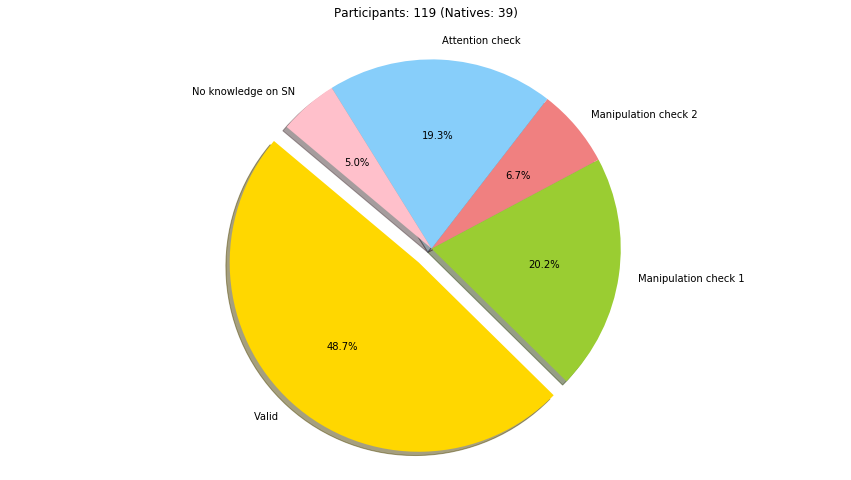

In [0]:
total_participants = filtered_data.shape[0]
native_participants = filtered_data[filtered_data['native_lang'] == 1].shape[0]
#Manipulation check
#Unnoticed mistakes
manip_disc_condition_1 = (filtered_data.mistakes > NO_MISTAKES) & (filtered_data.manip_check < AGREE)
unnoticed_mistakes_count = len(filtered_data[manip_disc_condition_1])
manip1_df = filtered_data[~manip_disc_condition_1]

#Noticing mistakes when there are no mistakes
manip_disc_condition_2 = (manip1_df.mistakes == NO_MISTAKES) & (manip1_df.manip_check > NEUTRAL)
noticed_wrong_mistakes_count = len(manip1_df[manip_disc_condition_2])
manip2_df = manip1_df[~manip_disc_condition_2]

#Attention check
att_disc_condition = manip2_df.att_check != manip2_df.social_net
discarded_att_check = len(manip2_df[att_disc_condition])

att_df = manip2_df[~att_disc_condition]

#No social net knowledge
knowledge_disc_condition = att_df.sn_knowledge == IGNORES_SOCIAL_NET
ignores_social_net = len(att_df[knowledge_disc_condition])

final_data = att_df[~knowledge_disc_condition].drop(['manip_check', 'att_check', 'sn_knowledge'], axis = 1)


gender_dict = { 1: "Male",
                2: "Female",
                3: "Other"
              }
mistakes_dict = {  1: "No Mistakes"
                 , 2: "Typos"
                 , 3: "Grammos"
                }

social_net_dict = {
                  1: "Facebook",
                  2: "Twitter",
                  3: "LinkedIn"
                  }

education_dict =  {   1: "Some High School"
                    , 2: "High School"
                    , 3: "Practical oriented training"
                    , 4: "Bachelor's Degree"
                    , 5: "Master's Degree"
                    , 6: "Ph.D of higher"
                  }

native_dict =  { 1: True,
                 2: False
               }
final_data['gender'].replace(gender_dict, inplace = True)
final_data['mistakes'].replace(mistakes_dict, inplace = True)
final_data['social_net'].replace(social_net_dict, inplace = True)
final_data['education'].replace(education_dict, inplace = True)
final_data['native_lang'].replace(native_dict, inplace = True)

valid_answers = total_participants - unnoticed_mistakes_count - noticed_wrong_mistakes_count - discarded_att_check - ignores_social_net
print("Number of participants: ", total_participants, "(Natives:", native_participants, ")")
print("Valid answers: ", valid_answers)
print("Unnoticed mistakes: ", unnoticed_mistakes_count)
print("Noticed mistakes when there were no mistakes: ", noticed_wrong_mistakes_count)
print("Participants that didn't pay attention to the social net: ", discarded_att_check)
print("Participants that didn't know the given social network: ", ignores_social_net)

# Data to plot
labels = 'Valid', 'Manipulation check 1', 'Manipulation check 2', 'Attention check', 'No knowledge on SN'
sizes = [valid_answers, unnoticed_mistakes_count, noticed_wrong_mistakes_count, discarded_att_check, ignores_social_net]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'pink']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(15,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Participants: ' + str(total_participants) + " (Natives: " + str(native_participants) + ")\n")

plt.axis('equal')
plt.show()

# One Way ANOVA

Some stats for the 3 different conditions and their box plot

             count      mean       std  min  25%  50%  75%  max
mistakes                                                       
Grammos       21.0  2.238095  1.091089  1.0  1.0  2.0  3.0  4.0
No Mistakes   20.0  3.700000  0.978721  1.0  3.0  4.0  4.0  5.0
Typos         17.0  2.588235  1.175735  1.0  2.0  2.0  3.0  5.0


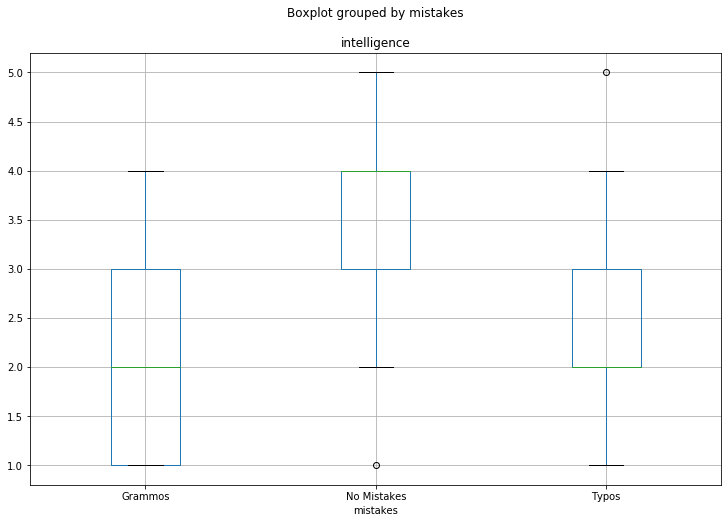

In [0]:
print(final_data.groupby(by = ['mistakes'])['intelligence'].describe())
#Create a boxplot
final_data.boxplot('intelligence', by='mistakes', figsize=(12, 8))

Separate the three conditons:

In [0]:
control_group = final_data[final_data.mistakes == 'No Mistakes'].intelligence
typos_condition = final_data[final_data.mistakes == 'Typos'].intelligence
grammos_condition = final_data[final_data.mistakes == 'Grammos'].intelligence

## One way ANOVA Hypothesis

H0: The means of all mistake groups are equal

H1: The mean of at least one mistake group is different

## One Way ANOVA Assumptions

### 1) Normality

Plot the three conditions to get an idea of their distributions

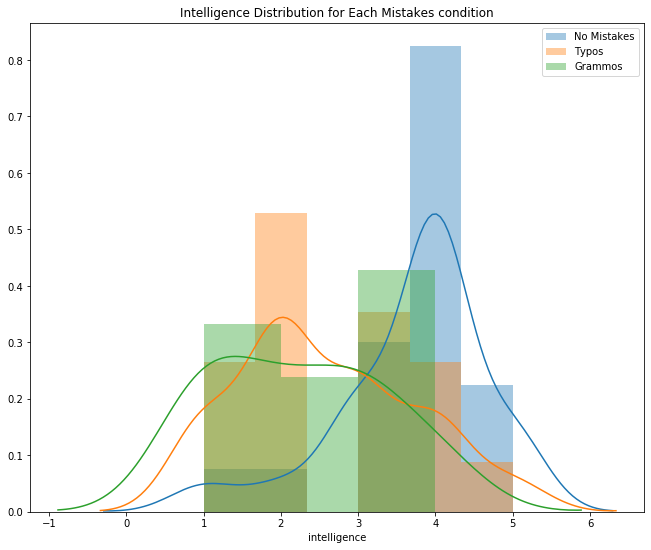

In [0]:
f, ax = plt.subplots(figsize=(11,9))

sns.distplot(control_group, ax=ax, label='No Mistakes')
sns.distplot(typos_condition, ax=ax, label='Typos')
sns.distplot(grammos_condition, ax=ax, label='Grammos')
plt.title('Intelligence Distribution for Each Mistakes condition')
plt.legend()

The Shapiro-Wilk test can be used to check the normal distribution assumption . Null hypothesis: data is drawn from normal distribution.

In [0]:
def print_shapiro(x):
  w, pvalue = stats.shapiro(x)
  pvalue = round(pvalue, 5)
  result = "p=" + str(pvalue) + " " + ("FAIL" if pvalue < 0.05 else "PASS")
  return result

print("No Mistakes: ", print_shapiro(control_group))
print("Typos: ", print_shapiro(typos_condition))
print("Grammos: ", print_shapiro(grammos_condition))

No Mistakes:  p=0.00228 FAIL
Typos:  p=0.12368 PASS
Grammos:  p=0.00573 FAIL


When the P-value is non significant, we fail to reject null hypothesis and conclude that data is drawn from normal distribution

### 2) Variance homogeneity

Levene test can be used to check the Homogeneity of variances. Null hypothesis: samples from populations have equal variances

In [0]:
# load packages
w, pvalue = stats.levene(control_group, 
                         typos_condition, 
                         grammos_condition)
pvalue = round(pvalue, 5)
print("p=" + str(pvalue) + " " + ("FAIL" if pvalue < 0.05 else "PASS"))

p=0.33448 PASS


As the P-value is non significant, we fail to reject null hypothesis and conclude that treatments have equal variances.

### 3) Independent observations

Satisfied with experimental design: between subjects design


## Applying One-way ANOVA

### Python function

The module scipy has the function f_oneway to calculate one way ANOVA, but it does not print the ANOVA table

In [0]:
import scipy.stats as stats

F, p = stats.f_oneway(control_group, 
                      typos_condition,
                      grammos_condition)

print("F =", F, "; p =", p)

F = 10.067458457384042 ; p = 0.00018807201276052735


### Proof of concept: One Way ANOVA calculations

We calculate One Way ANOVA by applying the given theory

In [0]:
groups = pd.unique(final_data.mistakes.values)
d_data = {grp:final_data['intelligence'][final_data.mistakes == grp] for grp in groups}

d_data
k = len(pd.unique(final_data.mistakes))  # number of conditions
N = len(final_data.values)  # Total number of participants

DFbetween = k - 1
DFwithin = N - k
DFtotal = N - 1

groups = pd.unique(final_data.mistakes.values)
mean_per_factor_level = {grp:final_data['intelligence'][final_data.mistakes == grp].mean() for grp in groups}

control_group_mean = control_group.mean()
typos_condition_mean = typos_condition.mean()
grammos_condition_mean = grammos_condition.mean()

total_mean = final_data['intelligence'].mean()

mss_within = 0
for group in groups:
  mss_within += sum(list(map(lambda x: (x - mean_per_factor_level[group])**2, d_data[group])))
mss_within /= DFwithin

print("MSS Within: ", mss_within)

mss_between = 0
for group in groups:
  mss_between += len(final_data[final_data.mistakes == group])*(mean_per_factor_level[group] - total_mean)**2
mss_between /= DFbetween

print("MSS Between: ", mss_between)
  
F_emp = mss_between/mss_within
p_calc = stats.f.sf(F_emp, DFbetween, DFwithin)
print("F Emp =", F_emp, "; p calc. =", p_calc)

MSS Within:  1.165948561242679
MSS Between:  11.738138703757368
F Emp = 10.067458457384046 ; p calc. = 0.00018807201276052656


We can see that the results match with the python function

## ANOVA One way Table

We are able to print the ANOVA Table with the following code:

In [0]:
model = ols('intelligence ~ C(mistakes)', final_data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
print(aov_table)

                sum_sq    df          F    PR(>F)
C(mistakes)  23.476277   2.0  10.067458  0.000188
Residual     64.127171  55.0        NaN       NaN


As the p-value is less than the significance level 0.05, we can conclude that there are significant differences between the groups

## Post hoc test

After getting a significant result, we find where the differences are by using a Tukey's HSD post hoc test. H0: group 1 and group 2 have the same mean

In [0]:
# load packages
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform multiple pairwise comparison (Tukey HSD)
m_comp_res = pairwise_tukeyhsd(endog=final_data['intelligence'], groups=final_data['mistakes'], alpha=0.05)
print(m_comp_res)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
    Grammos No Mistakes   1.4619  0.001  0.6493  2.2745   True
    Grammos       Typos   0.3501 0.5785 -0.4984  1.1987  False
No Mistakes       Typos  -1.1118 0.0079 -1.9698 -0.2538   True
--------------------------------------------------------------


The results suggest that the real difference lays on making or not making mistakes, since Typos and Grammos didn't present a significant result

#Two way ANOVA

Taking the previous result into consideration, we merge Typos and Grammos into one condition: Mistakes

In [0]:
two_way_data = final_data.copy(deep=True)
binary_condition = pd.Series(map(lambda x: "No Mistakes" if x == "No Mistakes" else "Mistakes", final_data['mistakes']))
print(final_data.mistakes.head())
two_way_data['mistakes'] = binary_condition.values
two_way_data.head()

4         Grammos
7           Typos
9     No Mistakes
12        Grammos
16          Typos
Name: mistakes, dtype: object


,age,gender,grammar_importance,education,native_lang,intelligence,mistakes,social_net
4,5,Male,4,Bachelor's Degree,False,3.0,Mistakes,LinkedIn
7,6,Male,5,Master's Degree,False,2.0,Mistakes,Facebook
9,6,Male,4,Bachelor's Degree,False,4.0,No Mistakes,Twitter
12,5,Male,3,Bachelor's Degree,False,4.0,Mistakes,Facebook
16,6,Male,4,Master's Degree,False,2.0,Mistakes,LinkedIn


## Hypothesis

H0: The means of all mistake groups are equal
H1: The mean of at least one mistake group is different


H0: The means of the social_net groups are equal
H1: The mean of at least one social_net group is different


H0: There is no interaction between the mistakes and social_nets 
H1: There is interaction between the mistakes and social_nets 

## Assumptions

Now we will check the assumptions for each combined condition:

### 1) Normality

In [0]:
#Conditions
condition_dict = {}
for mistake_condition in ["Mistakes","No Mistakes"]: 
  for social_net_condition in social_net_dict.values():
    combined_condition_set = two_way_data[(two_way_data.mistakes == mistake_condition) & (two_way_data.social_net == social_net_condition)].intelligence
    combination = mistake_condition + "_" +  social_net_condition
    condition_dict.update({combination:combined_condition_set})

for k,v in condition_dict.items():
  print(k, "(", v.size, ")", print_shapiro(v))

Mistakes_Facebook ( 14 ) p=0.09641 PASS
Mistakes_Twitter ( 11 ) p=0.02511 FAIL
Mistakes_LinkedIn ( 13 ) p=0.0927 PASS
No Mistakes_Facebook ( 9 ) p=0.00118 FAIL
No Mistakes_Twitter ( 5 ) p=0.02138 FAIL
No Mistakes_LinkedIn ( 6 ) p=0.41504 PASS


### 2) Variance Homogeneity

In [0]:
# load packages
import scipy.stats as stats

w, pvalue = stats.levene(condition_dict["Mistakes_Facebook"]
                          , condition_dict["Mistakes_Twitter"]
                          , condition_dict["Mistakes_LinkedIn"]
                          , condition_dict["No Mistakes_Facebook"]
                          , condition_dict["No Mistakes_Twitter"]
                          , condition_dict["No Mistakes_LinkedIn"]
                          )
result = "p=" + str(pvalue) + " " + ("FAIL" if pvalue < 0.05 else "PASS")
print(result)

p=0.21592399101428508 PASS


### 3) Independent observations

Again, this condition is satisfied by the experimental design (between subjects design)

## Applying Two Ways ANOVA / Table

We get the Two Way ANOVA table with the following code:

In [0]:
# load packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
model = ols('intelligence ~ C(mistakes) + C(social_net) + C(mistakes):C(social_net)', data = two_way_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(mistakes),20.943305,1.0,17.635550,0.000105
C(social_net),3.233694,2.0,1.361485,0.265263
C(mistakes):C(social_net),0.292040,2.0,0.122958,0.884557
Residual,61.753213,52.0,NaN,NaN


# ANCOVA

You can do a basic ANCOVA using formulas with OLS. If you have an outcome y, categorical variable z and continuous variable x, you can just use y ~ z + x (if z is coded as numbers use y ~ c(z) + x).


An analysis of covariance (ANCOVA) is appropriate when examining for differences in a continuous dependent variable between groups, while controlling for the effect of additional author justinvariables. The “C” in ANCOVA denotes that a covariate is being inputted into the model, and this covariate examination can be applied to a between-subjects design, a within-subjects design, or a mixed-model design. ANCOVAs are frequently used in experimental studies when the researcher wants to account for the effects of an antecedent (control) variable.

In [0]:
model = ols('intelligence ~ C(mistakes) + age', data=final_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(mistakes),25.958609,2.0,12.336506,0.000049
age,14.678217,8.0,1.743910,0.113008
Residual,49.448954,47.0,NaN,NaN


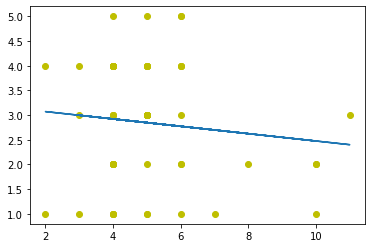

In [0]:
X = np.array((final_data)['age'],dtype='float')
Y = np.array((final_data)['intelligence'],dtype='float')

coef = np.polyfit(X,Y,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(X,Y, 'yo', X, poly1d_fn(X))


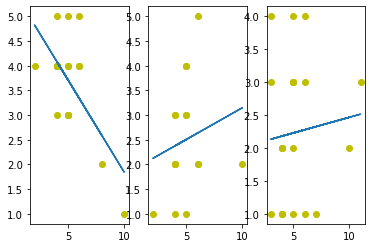

In [0]:
X_nm = np.array((final_data[final_data.mistakes == 'No Mistakes'])['age'],dtype='float')
Y_nm = np.array((final_data[final_data.mistakes == 'No Mistakes'])['intelligence'],dtype='float')

X_t = np.array((final_data[final_data.mistakes == 'Typos'])['age'],dtype='float')
Y_t = np.array((final_data[final_data.mistakes == 'Typos'])['intelligence'],dtype='float')

X_g = np.array((final_data[final_data.mistakes == 'Grammos'])['age'],dtype='float')
Y_g = np.array((final_data[final_data.mistakes == 'Grammos'])['intelligence'],dtype='float')

fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) # two axes on figure

coef = np.polyfit(X_nm,Y_nm,1)
poly1d_fn = np.poly1d(coef) 
ax1.plot(X_nm,Y_nm, 'yo', X_nm, poly1d_fn(X_nm))

coef = np.polyfit(X_t,Y_t,1)
poly1d_fn = np.poly1d(coef) 
ax2.plot(X_t,Y_t, 'yo', X_t, poly1d_fn(X_t))

coef = np.polyfit(X_g,Y_g,1)
poly1d_fn = np.poly1d(coef) 
ax3.plot(X_g,Y_g, 'yo', X_g, poly1d_fn(X_g))


In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

# import some data to play with
iris = datasets.load_iris()
column_names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df = pd.DataFrame(iris.data, columns=column_names)
df['target'] = iris['target']
#df.drop(['sepal_width', 'petal_length', 'petal_width'], axis = 1, inplace = True)
df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,target
79,5.7,2.6,3.5,1.0,1
53,5.5,2.3,4.0,1.3,1
107,7.3,2.9,6.3,1.8,2
24,4.8,3.4,1.9,0.2,0
3,4.6,3.1,1.5,0.2,0


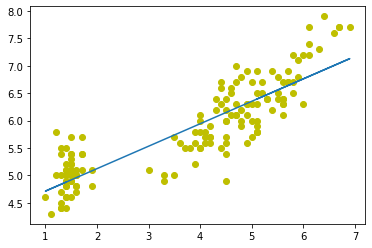

In [0]:
X = np.array((df)['petal_length'],dtype='float')
Y = np.array((df)['sepal_length'],dtype='float')

coef = np.polyfit(X,Y,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(X,Y, 'yo', X, poly1d_fn(X))

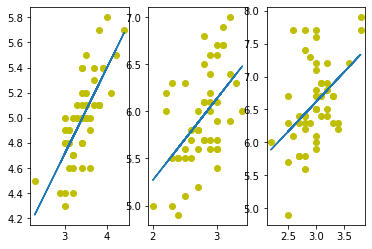

In [0]:
X_nm = np.array((df[df.target == 0])['sepal_width'],dtype='float')
Y_nm = np.array((df[df.target == 0])['sepal_length'],dtype='float')

X_t = np.array((df[df.target == 1])['sepal_width'],dtype='float')
Y_t = np.array((df[df.target == 1])['sepal_length'],dtype='float')

X_g = np.array((df[df.target == 2])['sepal_width'],dtype='float')
Y_g = np.array((df[df.target == 2])['sepal_length'],dtype='float')

fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3) # two axes on figure

coef = np.polyfit(X_nm,Y_nm,1)
poly1d_fn = np.poly1d(coef) 
ax1.plot(X_nm,Y_nm, 'yo', X_nm, poly1d_fn(X_nm))

coef = np.polyfit(X_t,Y_t,1)
poly1d_fn = np.poly1d(coef) 
ax2.plot(X_t,Y_t, 'yo', X_t, poly1d_fn(X_t))

coef = np.polyfit(X_g,Y_g,1)
poly1d_fn = np.poly1d(coef) 
ax3.plot(X_g,Y_g, 'yo', X_g, poly1d_fn(X_g))
